In [11]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
import pprint
from scipy import signal

In [12]:
def mean_spectrum(data, sampling_rate):
    """
    Plots the normalized mean spectrum of frequency for a 2D seismic shot gather.
    
    Parameters:
    - data: 2D numpy array (time samples x traces), seismic shot gather data.
    - sampling_rate: Sampling rate in Hz (number of samples per second).
    """
    # Number of time samples and traces
    n_samples, n_traces = data.shape
    
    # Fourier transform along the time axis (axis=0)
    fft_data = np.fft.fft(data, axis=0)
    
    # Calculate the frequency axis
    freq = np.fft.fftfreq(n_samples, d=1/sampling_rate)
    
    # Only keep the positive frequencies
    positive_freq = freq[:n_samples // 2]
    positive_fft = fft_data[:n_samples // 2, :]
    
    # Compute the amplitude spectrum
    amplitude_spectrum = np.abs(positive_fft)
    
    # Mean spectrum across all traces
    mean_spectrum = np.mean(amplitude_spectrum, axis=1)
    
    return positive_freq, mean_spectrum


def highpass_filter(data, freq, dt, pad=None):
    """
    Perform high-pass filter on data using SciPy.
    Args:
        freq (float): The cut-off frequency (in Hz).
        data (np.ndarray): Data to be filtered, shape (..., nt, :), where nt = number of time samples.
        dt (float): Time sampling rate of the data (in seconds).
        pad (int, optional): Padding size (before and after, with zeros) before filter.
                             Defaults to None (no padding).
    Returns:
        np.ndarray: High-pass filtered data.
    """
    # Apply padding if specified
    if pad is not None:
        pad_width = [(0, 0)] * (data.ndim - 2) + [(pad, pad), (0, 0)]
        data = np.pad(data, pad_width, mode='reflect')

    # Design the high-pass Butterworth filter
    nyquist = 0.5 / dt  # Nyquist frequency
    sos = signal.butter(8, freq / nyquist, btype='highpass', output='sos')

    # Apply the filter
    filtered_data = signal.sosfiltfilt(sos, data, axis=-2)

    # Remove padding if applied
    if pad is not None:
        filtered_data = filtered_data[..., pad:-pad, :]

    return filtered_data


## 01 Loading Data Real

In [3]:
path_file = "../data/sgy/viking_grabben.segy"
with segyio.open(path_file, ignore_geometry=True) as f:
    #01 Get Attribute
    f.mmap()
    field_record_attribute = f.attributes(segyio.TraceField.FieldRecord)[:]

    #02 Making template
    shot_data = {}
    for idx_fr in np.unique(field_record_attribute):
        shot_data[idx_fr] = []

    #03 Assign Data
    for i in range(f.tracecount):
        header_trace = f.header[i][segyio.TraceField.FieldRecord]
        shot_data[header_trace].append(f.trace[i])
    

## 02 Normalize and Pacthes

In [14]:
import cv2

(max_height, max_width) = (1500, 600)

increament = 5
patches_size = 128
idx_width = np.arange(0, (max_width-patches_size) , increament)
idx_height = np.arange(0, (max_height-patches_size) , increament)
num_shot_data = int(0.7*len(shot_data))
dt = 4e-3
raw_data_real = []
raw_data_real_5Hz = []
raw_data_real_10Hz = []
for i in range(num_shot_data):
    fr_choice =  np.random.choice(field_record_attribute)
    csg = np.array(shot_data[fr_choice]).T
    mean_csg = np.mean(csg)
    std_csg = np.std(csg)
    norm_csg = (csg-mean_csg) / std_csg
    norm_csg_int = cv2.resize(norm_csg, (max_width, max_height), interpolation=cv2.INTER_CUBIC)
    norm_csg_int_hpf_5 = highpass_filter(norm_csg_int, 5, dt, pad=32)
    norm_csg_int_hpf_10 = highpass_filter(norm_csg_int, 10, dt, pad=32)
    
    for _ in range(20):
        idx_width_random = np.random.choice(idx_width)
        idx_heigth_random = np.random.choice(idx_height)
    
        cols_end = idx_width_random + patches_size
        rows_end = idx_heigth_random + patches_size
        
        crop_img = norm_csg_int[idx_heigth_random:rows_end,idx_width_random:cols_end]
        raw_data_real.append(crop_img)

        crop_img_5Hz = norm_csg_int_hpf_5[idx_heigth_random:rows_end,idx_width_random:cols_end]
        raw_data_real_5Hz.append(crop_img_5Hz)
        
        crop_img_10Hz = norm_csg_int_hpf_10[idx_heigth_random:rows_end,idx_width_random:cols_end]
        raw_data_real_10Hz.append(crop_img_10Hz)

## 03 QC Shot Gather

QC Spectrum Frequency

In [15]:
print(len(raw_data_real_5Hz))
print(len(raw_data_real_10Hz))

14000
14000


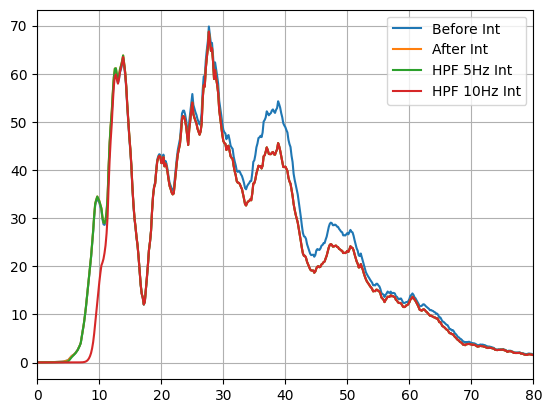

In [20]:
sampling_rate = 1 / (4e-3)
freq, spectrum = mean_spectrum(norm_csg, sampling_rate)
freq, spectrum_int = mean_spectrum(norm_csg_int, sampling_rate)

freq, spectrum_int_hpf5hz = mean_spectrum(norm_csg_int_hpf_5, sampling_rate)
freq, spectrum_int_hpf10hz = mean_spectrum(norm_csg_int_hpf_10, sampling_rate)

plt.plot(freq, spectrum, label="Before Int")
plt.plot(freq, spectrum_int, label="After Int")
plt.plot(freq, spectrum_int_hpf5hz, label="HPF 5Hz Int")
plt.plot(freq, spectrum_int_hpf10hz, label="HPF 10Hz Int")

plt.grid()
plt.xlim(0, 80)
plt.legend()

QC Shot Gather Data

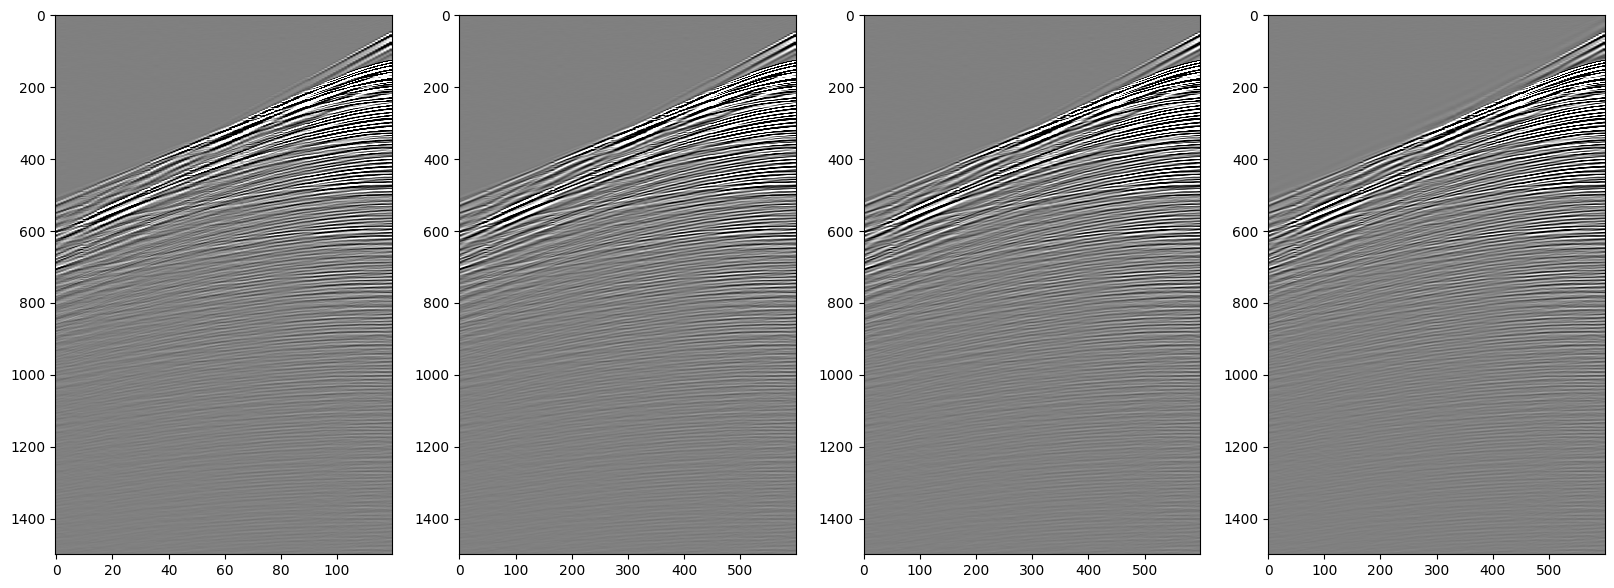

In [22]:
cval=1
plt.figure(figsize=(20, 7))
plt.subplot(1, 4, 1)
plt.imshow(norm_csg, aspect="auto", cmap="gray", vmin=-cval, vmax=cval)
plt.subplot(1, 4, 2)
plt.imshow(norm_csg_int, aspect="auto", cmap="gray", vmin=-cval, vmax=cval)
plt.subplot(1, 4, 3)
plt.imshow(norm_csg_int_hpf_5, aspect="auto", cmap="gray", vmin=-cval, vmax=cval)
plt.subplot(1, 4, 4)
plt.imshow(norm_csg_int_hpf_10, aspect="auto", cmap="gray", vmin=-cval, vmax=cval)

QC Patch data

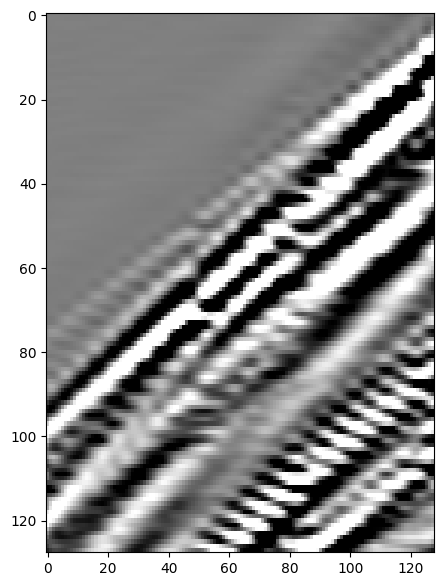

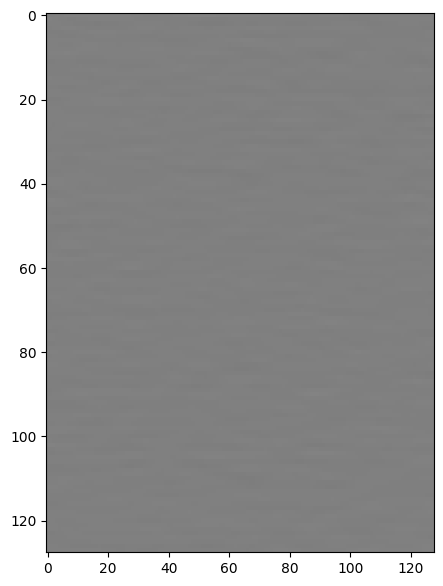

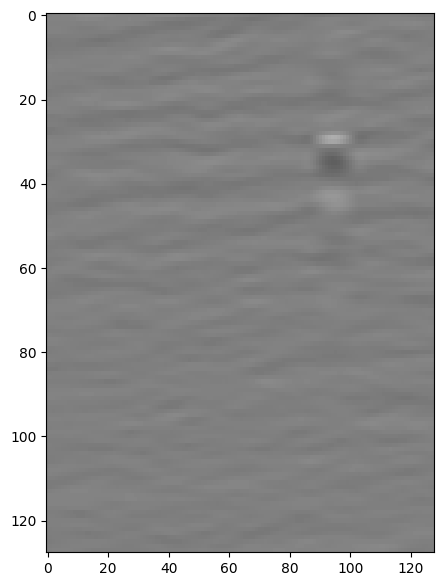

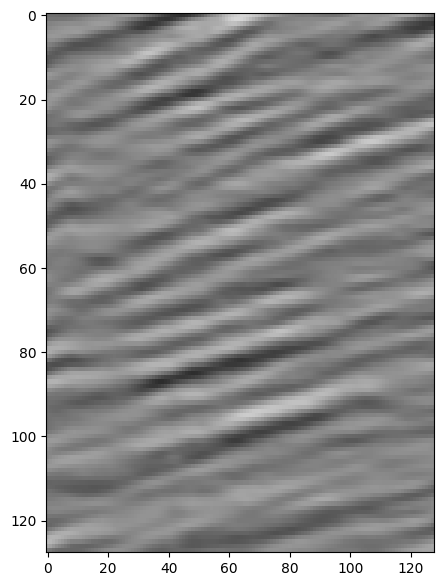

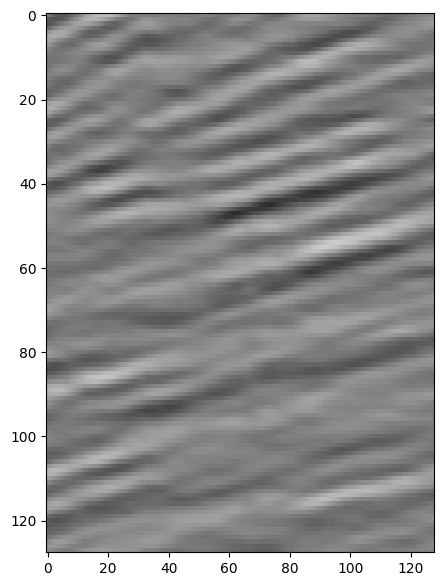

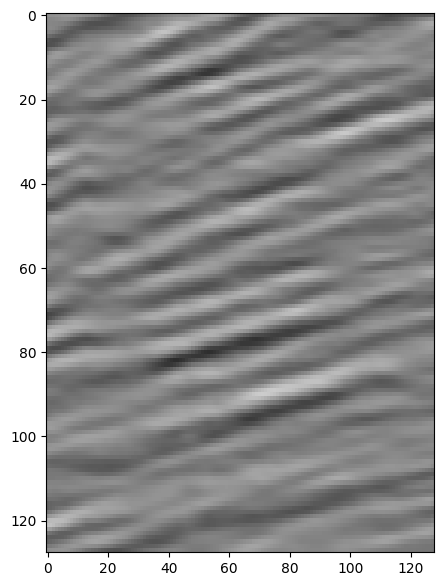

In [24]:
cval=1
plt.close("all")
for i, rd in enumerate(raw_data_real_10Hz):
    if rd.shape != (128, 128):
        print(rd.shape)

    plt.figure(figsize=(5, 7))
    plt.imshow(rd, aspect="auto", cmap="gray", vmin=-cval, vmax=cval)

    if i == 5:
        break
    

Saving raw dataset

In [26]:
np.save("../data/datasets/raw_data_real.npy", raw_data_real)
np.save("../data/datasets/raw_data_real_5Hz.npy", raw_data_real_5Hz)
np.save("../data/datasets/raw_data_real_10Hz.npy", raw_data_real_10Hz)